In [81]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchtext.transforms as T
from torch import optim
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.schemas.nlp import NlpContext
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.text import is_corpus_title, is_longer_text
from torchlake.text_classification.datasets.ag_news.constants import \
    CLASS_NAMES as AG_NEWS_CLASS_NAMES
from torchlake.text_classification.models.vdcnn import VDCNN
from torchlake.common.utils.text import build_vocab
from torchlake.text_classification.constants.misc import CHARACTERS
from torchtext.datasets import AG_NEWS

# setting


In [82]:
DATASET_NAME = "AGNews"

In [83]:
artifact_path = Path('../../artifacts/vdcnn')
data_path = Path('../../data') / DATASET_NAME

In [84]:
NUM_CLASS = len(AG_NEWS_CLASS_NAMES)

In [85]:
CONTEXT = NlpContext(max_seq_len=256)

In [86]:
BATCH_SIZE = 128
MINIMUM_LENGTH = 5

In [87]:
DEVICE = torch.device(CONTEXT.device)

In [88]:
def datapipe_factory(
    datapipe,
    minimum_length: int = 1,
    transform=None,
):
    datapipe = (
        datapipe.map(lambda pair: (pair[0], pair[1].strip())) # label, text
        .map(lambda pair: (pair[0], pair[1].lower()))
        .filter(lambda pair: is_longer_text(pair[1], minimum_length))
        .filter(lambda pair: not is_corpus_title(pair[1]))
        .map(lambda pair: (pair[0], [*pair[1]])) # label, chars
    )  

    if transform:
        datapipe = datapipe.map(
            lambda pair: (
                transform(pair[1]),
                pair[0] - 1,
            )  # tokens, label
        )

    return datapipe

In [89]:
train_datapipe, test_datapipe = AG_NEWS(data_path.as_posix())

In [90]:
vocab = build_vocab(
    CHARACTERS,
    context=NlpContext(min_frequency=0),
)

In [91]:
VOCAB_SIZE = len(vocab)

In [92]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [93]:
train_datapipe = datapipe_factory(
    train_datapipe,
    MINIMUM_LENGTH,
    text_transform,
)

test_datapipe = datapipe_factory(
    test_datapipe,
    MINIMUM_LENGTH,
    text_transform,
)

In [94]:
count = 0
for text, label in train_datapipe:
    print(text.shape)
    print(label)
    if count > 10:
        break
    count+=1

torch.Size([256])
2
torch.Size([256])
2
torch.Size([256])
2
torch.Size([256])
2
torch.Size([256])
2
torch.Size([256])
2
torch.Size([256])
2
torch.Size([256])
2
torch.Size([256])
2
torch.Size([256])
2
torch.Size([256])
2
torch.Size([256])
2


In [95]:
NUM_WORKERS = get_num_workers()

In [96]:
train_dataloader = DataLoader(
    train_datapipe,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

test_dataloader = DataLoader(
    test_datapipe,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

In [97]:
count = 0
for text, label in train_dataloader:
    print(text.shape)
    print(label.shape)
    if count > 10:
        break
    count+=1

torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])


# training


In [98]:
EPOCHS = 10
ACC_ITERS = max(1, 32 / BATCH_SIZE)
LR = 1e-4

In [99]:
trainer = ClassificationTrainer(EPOCHS, DEVICE, ACC_ITERS)

In [100]:
model = VDCNN(
    VOCAB_SIZE,
    NUM_CLASS,
    depth_multipier=1,
    context=CONTEXT,
).to(DEVICE)

In [101]:
loss = trainer.get_criterion(NUM_CLASS)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [102]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
Vdcnn                                         --
├─ModuleDict: 1-1                             --
│    └─Embedding: 2-1                         1,152
│    └─Conv1d: 2-2                            3,136
├─Sequential: 1-2                             --
│    └─Block: 2-3                             --
│    │    └─Sequential: 3-1                   24,832
│    │    └─Identity: 3-2                     --
│    └─Block: 2-4                             --
│    │    └─Sequential: 3-3                   24,832
│    │    └─ConvBnRelu: 3-4                   4,224
│    └─Block: 2-5                             --
│    │    └─Sequential: 3-5                   74,240
│    │    └─ConvBnRelu: 3-6                   8,448
│    └─Block: 2-6                             --
│    │    └─Sequential: 3-7                   98,816
│    │    └─ConvBnRelu: 3-8                   16,640
│    └─Block: 2-7                             --
│    │    └─Sequential: 3-9     

In [103]:
training_loss = trainer.run(train_dataloader, model, optimizer, loss)

938it [00:48, 19.50it/s]


epoch 1 : 0.006101254427184661


938it [00:51, 18.11it/s]


epoch 2 : 0.003551024088387688


938it [00:49, 18.93it/s]


epoch 3 : 0.00281610206750532


938it [00:49, 19.00it/s]


epoch 4 : 0.002298118785303086


938it [00:45, 20.81it/s]


epoch 5 : 0.0018999288585347435


938it [00:42, 22.02it/s]


epoch 6 : 0.0016046384810780485


938it [00:42, 21.98it/s]


epoch 7 : 0.0013650515599176287


938it [00:42, 22.01it/s]


epoch 8 : 0.0011829806957083444


938it [00:42, 22.02it/s]


epoch 9 : 0.0010264907319331542


938it [00:42, 22.07it/s]

epoch 10 : 0.0008902401301272524


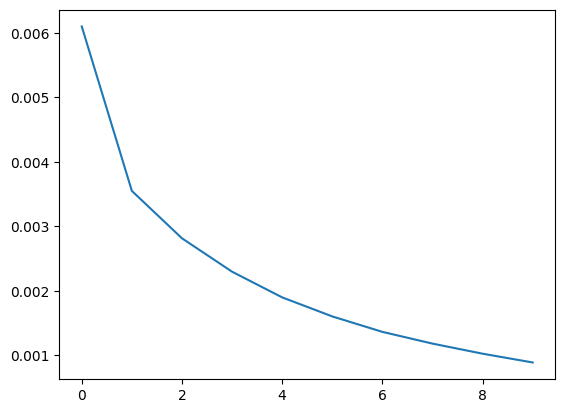

In [104]:
plt.plot(training_loss)

# Inference

In [105]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE, feature_dim=-1)

In [106]:
confusion_matrix = evaluator.run(iter(test_dataloader), model)

59it [00:01, 31.89it/s]

[[1715   46   49   55]
 [  86 1722   23   40]
 [ 247   23 1375  238]
 [ 186   19  103 1545]]


In [107]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(AG_NEWS_CLASS_NAMES, per_class_acc)

world     : 0.9195710455764075
sports    : 0.9203634420096205
business  : 0.7302177376526819
science   : 0.8337830545062062


In [108]:
per_class_acc.mean()

0.850983819936229

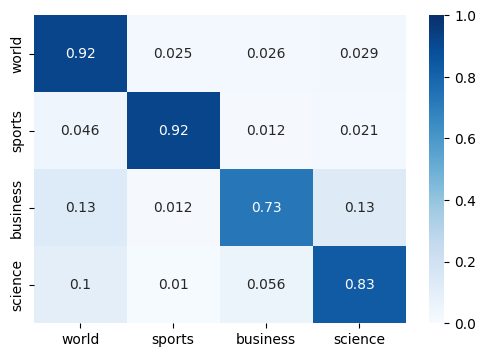

In [109]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    AG_NEWS_CLASS_NAMES,
    "Blues",
    annot=True,
    figsize=(6, 4),
)

# File


In [110]:
model_path = artifact_path / "vdcnn.pth"

In [111]:
torch.save(model.state_dict(), model_path)

In [112]:
get_file_size(model_path)

'63.14MB'

In [113]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>